In [2]:
#import mdtraj
import os

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem
from molvs import Standardizer

In [3]:
ifilename = "molekula.txt"
picture_dimensions = (900, 400)

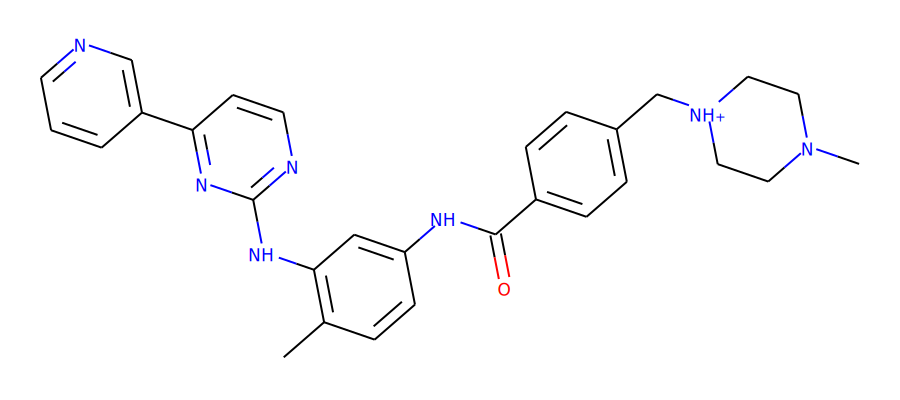

In [4]:
from render_svg import *

ifile = open(ifilename, "r").readlines()
smiles_molecule = str.split(ifile[0])[0]

molecule = Chem.MolFromSmiles(smiles_molecule)

render_svg(moltosvg(molecule, picture_dimensions))

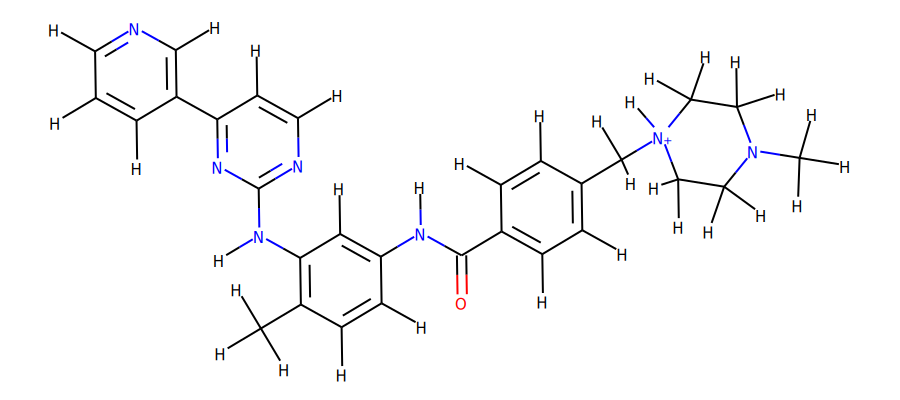

In [5]:
smifile = open("molekula.smi", "w")
smifile.write(smiles_molecule)
smifile.close()

molecule = Chem.MolFromSmiles(smiles_molecule)
#Draw.MolToFile(molecule,'molekula.png')
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()

render_svg(moltosvg(molecule, picture_dimensions))

In [6]:
#set parameters
numc = 50 #00
minid = 0
minene = 100000000000.0

In [9]:
molecules = AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)
done = AllChem.MMFFOptimizeMoleculeConfs(molecule)

for i in range(len(done)):
  if done[i][1]<minene:
    minene = done[i][1]
    minid = i
print(f'minid: {minid}')
print(f'minene: {minene}')

minid: 18
minene: 76.3893611924326


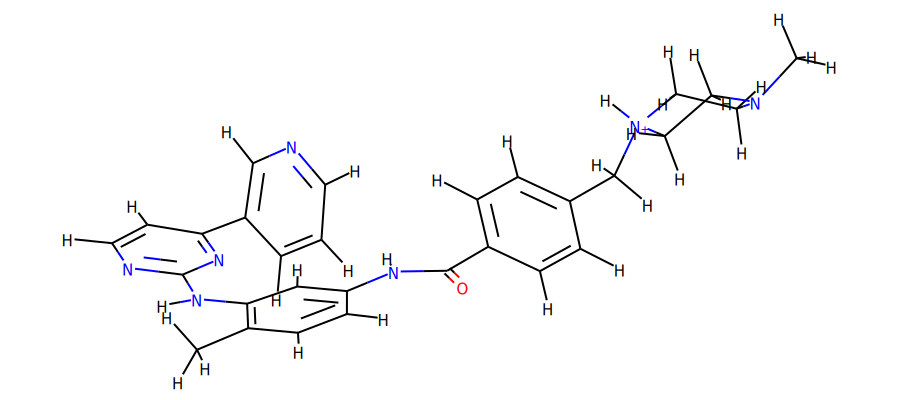

In [12]:
writer = SDWriter("molekula.mol")
writer.write(molecule, confId=minid)

render_svg(moltosvg(molecule, picture_dimensions))